#                         Cats and Dogs Classification
* ### The purpose of this notebook is to classify images of dogs and cats.
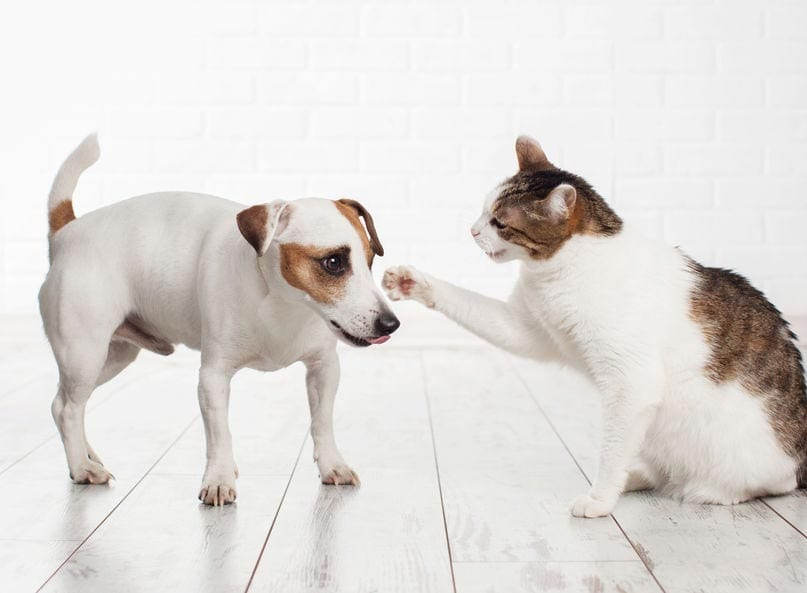

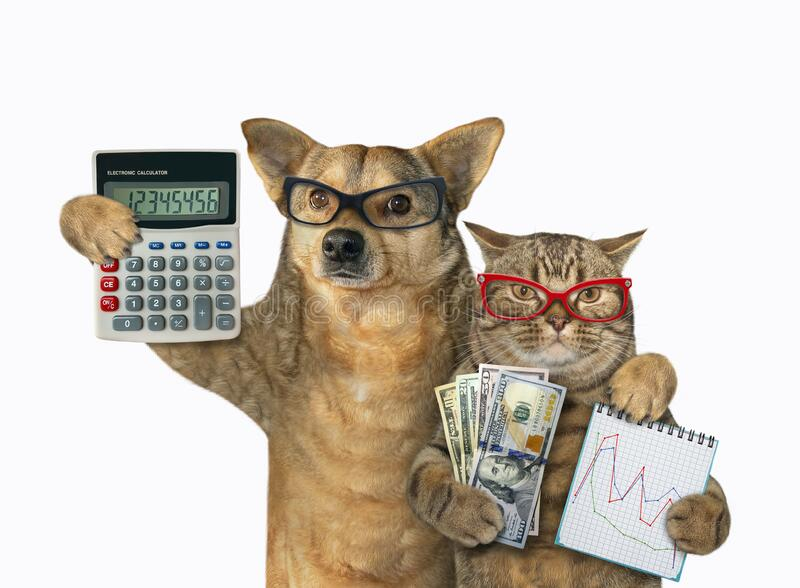

In [131]:
import os
import zipfile
import cv2
import seaborn as sns
import numpy as np
import pandas as pd 
import random

from matplotlib import pyplot
from matplotlib.image import imread

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.dummy import DummyClassifier


import matplotlib.pyplot as plt

In [2]:
ROWS = 64 
COLS = 64 

classes = ['cats', 'dogs']

In [3]:
base_dir = r'C:\Users\Aviva\Desktop\dogs-vs-cats'
train_dir = os.path.join(base_dir, "train.zip")
test_dir = os.path.join(base_dir, "test1.zip")

with zipfile.ZipFile(train_dir,"r") as z:
    z.extractall("/kaggle/")

with zipfile.ZipFile(test_dir, "r") as z:
    z.extractall("/kaggle/")

# categories:
* ## cat = 0
* ## dog = 1

In [4]:
filenames = os.listdir("/kaggle/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

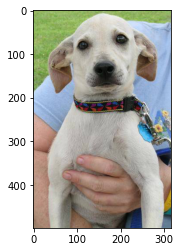

In [75]:
sample = random.choice(filenames)
img = imread("/kaggle/train/"+sample)
cv2.imshow('image',img)
plt.imshow(img)

# Cleaning the data
* #### I manually went through the pictures and found pictures that I think could confuse the model:

In [6]:
bad_dog_ids = [5604, 6413, 8736, 8898, 9188, 9517, 10161, 
               10190, 10237, 10401, 10797, 11186]

bad_cat_ids = [2939, 3216, 4688, 4833, 5418, 6215, 7377, 
               8456, 8470, 11565, 12272]

bad_dog_cat_list =[]
for id in bad_cat_ids:
    bad_dog_cat_list.append('cat.'+str(id)+'.jpg')
    
for id in bad_dog_ids:
    bad_dog_cat_list.append('dog.'+str(id)+'.jpg')

* ### We will present the bad pictures before deleting them:

In [7]:
def load_images(ids, categ):
  '''return the images corresponding to a list of ids'''
  images = []
  dirname = categ+'s' # dog -> dogs
  for theid in ids: 
    fname = '/kaggle/train/{categ}.{theid}.jpg'.format(
        dirname=dirname,
        categ=categ, 
        theid=theid
    )
    im = imread(fname)
    images.append(im)
  return images

In [8]:
bad_dogs = load_images(bad_dog_ids, 'dog')
bad_cats = load_images(bad_cat_ids, 'cat')

In [9]:
def plot_images(images, ids):
    ncols, nrows = 4, 3
    fig = plt.figure( figsize=(ncols*3, nrows*3), dpi=90)
    for i, (img, theid) in enumerate(zip(images,ids)):
      plt.subplot(nrows, ncols, i+1)
      plt.imshow(img)
      plt.title(str(theid))
      plt.axis('off')

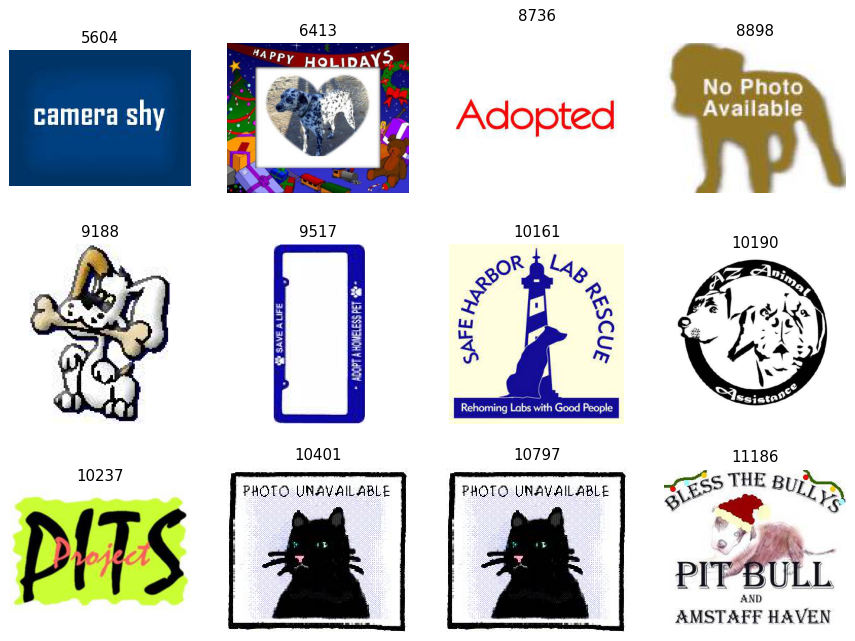

In [10]:
plot_images(bad_dogs, bad_dog_ids)

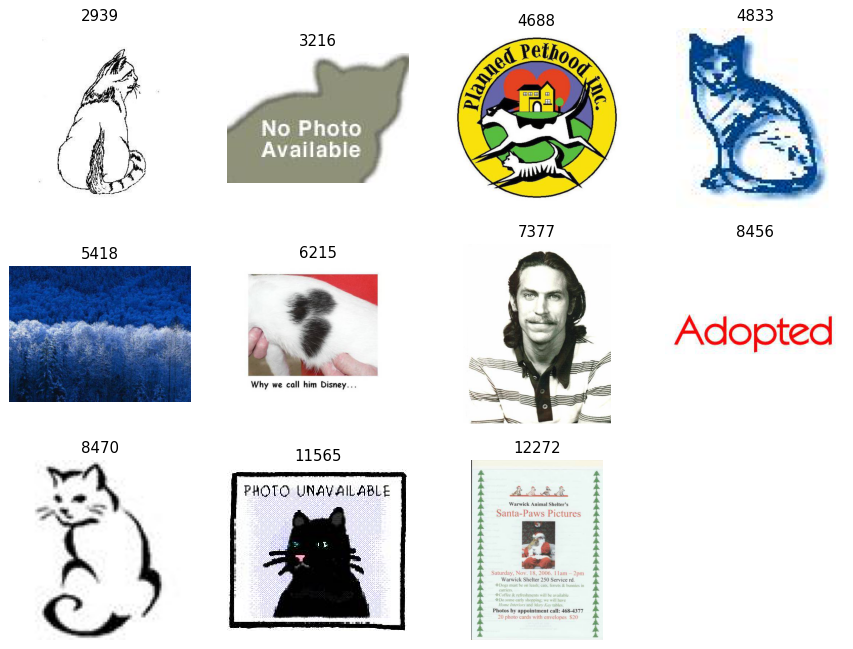

In [11]:
plot_images(bad_cats, bad_cat_ids)

In [12]:
# read image as grayscale

def read_image_grayscale (file_path):
  img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
  return cv2.resize(img, (64, 64), interpolation=cv2.INTER_CUBIC)

## Creates  dataframe of grayscale

In [20]:
# Creates that the first DataFrame:
df_gray = pd.DataFrame({
    'filename': filenames,
    'category': categories,
})
#---------------------------------------


# Creates a columns names for the secend dataframe
columns=[]
for i in range(1,4097):
    temp = "pixel {}".format(str(i))
    columns.append(temp)
#----------------------------------------    


# Creates a dataframe of the images:
data_gray =[]
for fname in df_gray['filename']:
    file_path = os.path.join("/kaggle/train/"+fname)
    img = read_image_grayscale(file_path)
    img = img.flatten() 
    data_gray.append(img)
df_img_gry = pd.DataFrame.from_records(data_gray,columns=columns)
#----------------------------------------    


# "Merge" the 2 dataframe to 1:
df_img_gry = pd.concat([df_img_gry, df_gray], axis=1)
#----------------------------------------    


# clean up the dataset:
filenames = os.listdir("/kaggle/train")
i=0
for filename in filenames:    
    data_name = df_img_gry['filename'][i]
    if data_name in bad_dog_cat_list:
        df_img_gry=df_img_gry.drop([i],axis=0)
        print(data_name+" is delet from df_img_gry")
    i=i+1
#----------------------------------------    

df_img_gry = df_img_gry.drop(['filename'],axis=1)

df_img_gry

cat.11565.jpg is delet from df_img_gry
cat.12272.jpg is delet from df_img_gry
cat.2939.jpg is delet from df_img_gry
cat.3216.jpg is delet from df_img_gry
cat.4688.jpg is delet from df_img_gry
cat.4833.jpg is delet from df_img_gry
cat.5418.jpg is delet from df_img_gry
cat.6215.jpg is delet from df_img_gry
cat.7377.jpg is delet from df_img_gry
cat.8456.jpg is delet from df_img_gry
cat.8470.jpg is delet from df_img_gry
dog.10161.jpg is delet from df_img_gry
dog.10190.jpg is delet from df_img_gry
dog.10237.jpg is delet from df_img_gry
dog.10401.jpg is delet from df_img_gry
dog.10797.jpg is delet from df_img_gry
dog.11186.jpg is delet from df_img_gry
dog.5604.jpg is delet from df_img_gry
dog.6413.jpg is delet from df_img_gry
dog.8736.jpg is delet from df_img_gry
dog.8898.jpg is delet from df_img_gry
dog.9188.jpg is delet from df_img_gry
dog.9517.jpg is delet from df_img_gry


,pixel 1,pixel 2,pixel 3,pixel 4,pixel 5,pixel 6,pixel 7,pixel 8,pixel 9,pixel 10,...,pixel 4088,pixel 4089,pixel 4090,pixel 4091,pixel 4092,pixel 4093,pixel 4094,pixel 4095,pixel 4096,category
0,170,176,183,188,192,196,200,202,205,208,...,9,3,3,3,2,2,2,2,2,0
1,43,41,34,26,40,44,70,37,35,37,...,66,36,38,57,61,53,73,74,28,0
2,47,46,46,57,56,50,59,50,52,45,...,80,90,143,161,150,139,150,171,158,0
3,220,222,232,226,234,226,225,227,229,226,...,241,235,228,211,205,205,220,214,213,0
4,115,124,83,87,138,151,127,193,210,230,...,98,106,95,93,90,100,108,95,87,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,141,142,145,147,149,148,150,152,153,153,...,163,164,164,165,167,167,168,168,169,1
24996,92,84,85,97,66,93,87,59,73,102,...,70,79,89,89,88,77,89,120,66,1
24997,36,49,43,35,49,56,45,68,43,34,...,162,140,110,137,101,94,220,144,170,1
24998,255,246,229,193,143,96,65,69,99,53,...,99,115,84,61,95,94,123,119,119,1


It can be seen that the amount of dogs and the amount of cats are balanced:


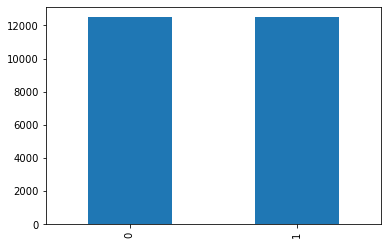

In [25]:
print ("It can be seen that the amount of dogs and the amount of cats are balanced:")
df_img_gry['category'].value_counts().plot.bar()

In [22]:
# train test split:
y = df_img_gry['category']
X = df_img_gry.drop("category",axis=1) 
    
X_train_gray, X_test_gry, y_train, y_test_gry = train_test_split(X, y, test_size=0.1, random_state=42)

In [24]:
# Checks for missing values:

X_train_gray.isnull().sum().sum()

0

In [27]:
#Normalize features:
scaler = StandardScaler()
X_train_gray_sc = scaler.fit_transform(X_train_gray)
X_train_gray_sc

array([[-1.61575763, -1.63234669, -1.64415682, ...,  1.19267687,
         1.20632536,  1.21431484],
       [ 0.71215831,  0.57832691,  0.54192127, ..., -0.84142596,
        -1.00460027, -0.70802735],
       [ 1.04063724,  1.08075273,  1.10282289, ..., -0.01271739,
        -0.01193978, -0.04722222],
       ...,
       [-0.68744759, -0.67056013, -0.65179242, ..., -1.11263967,
        -1.27532586, -1.36883248],
       [ 0.81213016,  1.06639771,  0.55630336, ...,  0.90639574,
         1.22136567,  0.74874759],
       [-0.24471511, -0.21119938,  0.55630336, ...,  1.04200259,
         0.28886643,  0.31321694]])

* ### I chose to working with the data on grayscale and see what results can be reached with it. In this data, the algorithms will run faster and it will facilitate the tests I want to do.
* ### We will now reduce the dimensions and see how this affects the data.
* ### We want to reduce as many dimensions as possible but maintain a sufficient amount in order to identify the difference between cat and dog.

In [76]:
SAMPLE_INDEX = 2 #The index of the image to show

In [78]:
# perform PCA and keep 350 components:

pca = PCA(n_components = 350, random_state=42)
X_reduced_350_gry = pca.fit_transform(X_train_gray_sc)

#Invert the PCA to obtain the image with the new components:
inv_350 = pca.inverse_transform(X_reduced_350_gry[SAMPLE_INDEX, :])
inv_350 = scaler.inverse_transform(inv_350) #Unnormalize

X_reduced_350_gry.shape

(22479, 350)

In [79]:
# perform PCA and keep 500 components:

pca = PCA(n_components = 500, random_state=42)
X_reduced_500_gry = pca.fit_transform(X_train_gray_sc)

#Invert the PCA to obtain the image with the new components:
inv_500 = pca.inverse_transform(X_reduced_500_gry[SAMPLE_INDEX, :])
inv_500 = scaler.inverse_transform(inv_500) #Unnormalize

X_reduced_500_gry.shape

(22479, 500)

In [80]:
# perform PCA and keep 95% of the variance -> 1119 components:

pca = PCA(n_components = 0.95, random_state=42)
X_reduced_095_gry = pca.fit_transform(X_train_gray_sc)

#Invert the PCA to obtain the image with the new components:
inv_095 = pca.inverse_transform(X_reduced_095_gry[SAMPLE_INDEX, :])
inv_095 = scaler.inverse_transform(inv_095) #Unnormalize

X_reduced_095_gry.shape

(22479, 1102)

(22479, 2000)

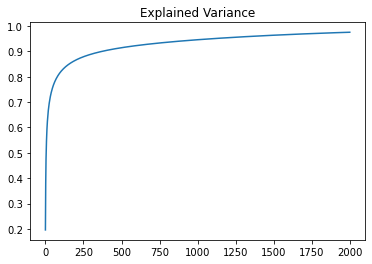

In [81]:
# perform PCA and keep 2000 components:

pca = PCA(n_components = 2000, random_state=42)
X_reduced_2000_gry = pca.fit_transform(X_train_gray_sc)


#Plot Component-wise and Cumulative Explained Variance:
plt.subplot(1, 1, 1)
plt.plot(range(2000), np.cumsum(pca.explained_variance_ratio_))
plt.title("Explained Variance", fontsize=12)


#Invert the PCA to obtain the image with the new components:
inv_2000 = pca.inverse_transform(X_reduced_2000_gry[SAMPLE_INDEX, :])
inv_2000 = scaler.inverse_transform(inv_2000) #Unnormalize

X_reduced_2000_gry.shape

##### Let's now inverse transform the data to view how the data changes because of the PCA:


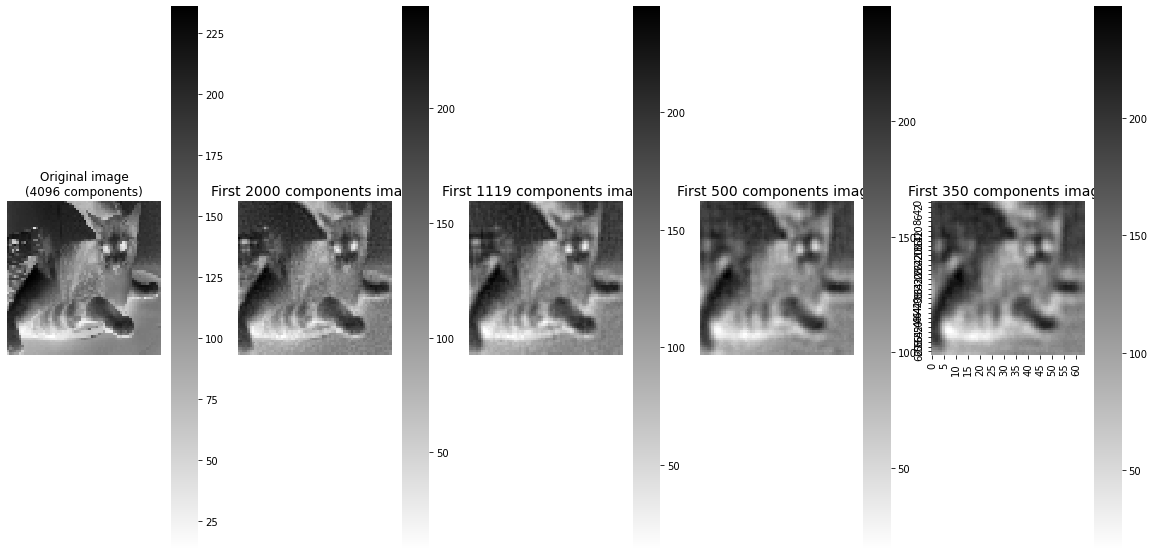

In [82]:
#Plot images:
fig, axarr = plt.subplots(1, 5, figsize=(20, 10))
sns.heatmap(X_train_gray.iloc[SAMPLE_INDEX, :, ].values.reshape(ROWS, COLS), cmap='gray_r', ax=axarr[0])
sns.heatmap(inv_2000.reshape(ROWS, COLS), cmap='gray_r', ax=axarr[1])
sns.heatmap(inv_095.reshape(ROWS, COLS), cmap='gray_r', ax=axarr[2])
sns.heatmap(inv_500.reshape(ROWS, COLS), cmap='gray_r', ax=axarr[3])
sns.heatmap(inv_350.reshape(ROWS, COLS), cmap='gray_r', ax=axarr[4])


axarr[0].set_title("Original image\n({} components)".format(X_train_gray.shape[1]), fontsize=12)
axarr[1].set_title("First {} components image".format(2000), fontsize=14)
axarr[2].set_title("First {} components image".format(1119), fontsize=14)
axarr[3].set_title("First {} components image".format(500), fontsize=14)
axarr[4].set_title("First {} components image".format(350), fontsize=14)

axarr[0].set_aspect('equal')
axarr[1].set_aspect('equal')
axarr[2].set_aspect('equal')
axarr[3].set_aspect('equal')
axarr[4].set_aspect('equal')
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[3].axis('off')
axarr[3].axis('off')


plt.show()

# <u>Training a model</u>

### Logistic Regression
* ### We now want to understand whether or not the reduction of the dimension we did significantly harmed the data prediction 
* ### So let's try Logistic Regression with PCA of 500 components and compare it to Logistic Regression with PSA of 350 components and to Logistic Regression PCA with a retained variance of 0.95

In [35]:
#---------------Logistic Regression with PCA-----------------------
n_components = [0.65, 0.75, 350, 0.95]
accuracy_LG_PCA = []

for n in n_components:
    pipe_LG_PCA = Pipeline([
         ("pca", PCA(n_components=n, random_state=42)),
        ("scale", StandardScaler()),
        ('lg_clf', LogisticRegression(multi_class='ovr',max_iter=100000))
    ])

    y_pred_LG_PCA = cross_val_predict(pipe_LG_PCA, X_train_gray, y_train)

    #save the accuracy
    accuracy = accuracy_score(y_train,y_pred_LG_PCA)
    accuracy_LG_PCA.append(accuracy)

<function matplotlib.pyplot.show(*args, **kw)>

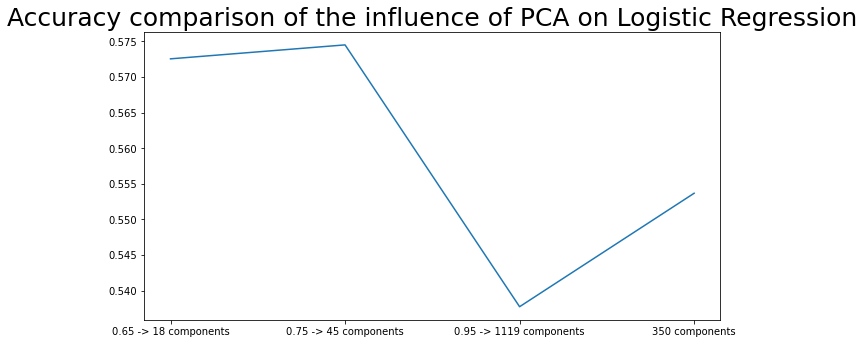

In [39]:
Models = ["0.65 -> 18 components", "0.75 -> 45 components", "350 components","0.95 -> 1119 components"]

fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([0,0,1,1])
x = Models
y = accuracy_LG_PCA
sns.lineplot(x=x, y=y)
plt.title("Accuracy comparison of the influence of PCA on Logistic Regression",fontsize=25)
plt.show

* ### It can be deduced from the graph that clearly we do not need that all of the dimensions, and even multi-dimensionality impairs our accuracy.
* ### In addition, it can be seen that the use of a quantity of dimensions that explain the data at the level of 65-75 percent, provide us with pretty good models
* ### Furthermore, it should be noted that our task was to produce the most accurate model with the smallest amount of dimensions, we will then focus on reducing the dimensions to a range of 65-75 percent understanding of the data
* ### with <u>18</u> dimensions i get accuracy of <u>0.5725343654077139</u> # 


### Random Forest Classifier


In [40]:
#---------------Random Forest Classifier with PCA---------------
n_components = [0.60, 0.65, 0.70, 0.75, 0.95]
accuracy_RF_PCA = []

for n in n_components:
    pipe_RF_PCA = Pipeline([
         ("pca", PCA(n_components=n, random_state=42)),
        ("scale", StandardScaler()),
        ('rf_clf', RandomForestClassifier())
    ])

    y_pred_RF_PCA = cross_val_predict(pipe_RF_PCA, X_train_gray, y_train)

    #save the accuracy
    accuracy = accuracy_score(y_train,y_pred_RF_PCA)
    accuracy_RF_PCA.append(accuracy)

<function matplotlib.pyplot.show(*args, **kw)>

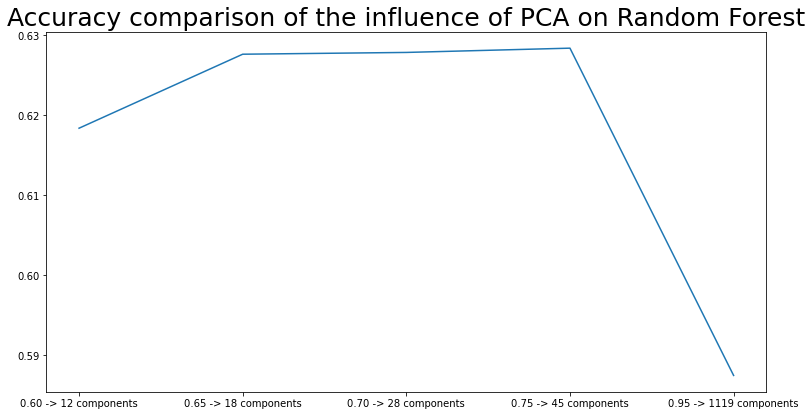

In [41]:
Models = ["0.60 -> 12 components", "0.65 -> 18 components", "0.70 -> 28 components", "0.75 -> 45 components", "0.95 -> 1119 components"]

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
x = Models
y = accuracy_RF_PCA
sns.lineploteplot(x=x, y=y)
plt.title("Accuracy comparison of the influence of PCA on Random Forest",fontsize=25)
plt.show

* ### It can be clearly seen as we have seen before, a model with almost all dimensions gives a less good result
* ### In addition it can be seen that the model works best with a PCA of 0.65 (with less of this and with more than that it works less well)
* ### Since I want to work with a model that is as simple as possible and with as few dimensions as possible I will choose to reduce my dimensions to a level of 65% explanation of variance of the data which are 18 dimensions, and this is a good dimension reduction in my opinion.
* ### with 18 dimensions i get accuracy of <u>0.6276524756439343</u> 

### Extra Trees Classifier
* ### We will now look for the best parameters for Extra Trees classifier
* ### The parameters I will focus on:
    * #### max_depth - The maximum depth of the tree. 
    * #### n_estimators - The number of trees in the forest.

In [95]:
#---------------Extra Trees Classifier with PCA-----------------------
retained_variance = np.linspace(5, 300, num=10)
accuracy_Ext = []

for n in retained_variance:
    n = int(n)
    pipe_EXT_PCA = Pipeline([
        ("pca", PCA(n_components=0.65, random_state=42)),
        ("scale", StandardScaler()),
        ('EXT', ExtraTreesClassifier(n_estimators=n))
    ])

    
    y_pred_EXT_PCA = cross_val_predict(pipe_EXT_PCA, X_train_gray, y_train)

    #save the accuracy
    accuracy = accuracy_score(y_train,y_pred_EXT_PCA)
    accuracy_Ext.append(accuracy)

Text(0.5, 1.0, "The number of 'n_estimators' in relation to the accuracy we obtained on Extra Trees classifier")

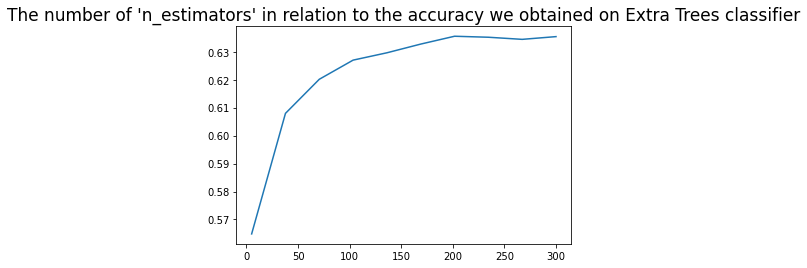

In [96]:
ax = plt.axes()
ax.plot(np.linspace(5, 300, num=10), accuracy_Ext)
plt.title("The number of 'n_estimators' in relation to the accuracy we obtained on Extra Trees classifier", fontsize=17, fontweight=100)

* ### The best 'n_estimators' is n=300

In [98]:
#---------------Extra Trees classifier with PCA-----------------------
max_depth = [1,2,3,4,6,8,10,12]
accuracy_Ext = []

for n in max_depth:
    pipe_EXT_PCA = Pipeline([
        ("pca", PCA(n_components=0.65, random_state=42)),
        ("scale", StandardScaler()),
        ('EXT', ExtraTreesClassifier(n_estimators=300, max_depth=n, random_state=42))
    ])

    
    y_pred_EXT_PCA = cross_val_predict(pipe_EXT_PCA, X_train_gray, y_train)

    #save the accuracy
    accuracy = accuracy_score(y_train,y_pred_EXT_PCA)
    accuracy_Ext.append(accuracy)

Text(0.5, 1.0, "The number of 'max_depth' in relation to the accuracy we obtained on Extra Trees classifier")

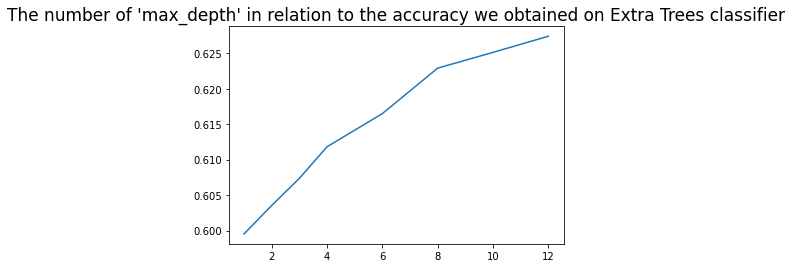

In [99]:
ax = plt.axes()
ax.plot(max_depth, accuracy_Ext)
plt.title("The number of 'max_depth' in relation to the accuracy we obtained on Extra Trees classifier", fontsize=17, fontweight=100)

* ### The best 'max_depth' is 'max_depth'=12 it's accuracy = <u>0.6273855598558655</u>  

### xgboost classifier
* ### We will now look for the best parameters for xgboost classifier
* ### The parameters I will focus on:
    * #### max_depth - Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 
    * #### n_estimators - Number of gradient boosted trees. Equivalent to number of boosting rounds.

In [43]:
import warnings
warnings.filterwarnings("ignore")

In [57]:
#---------------XGB Classifier with PCA---------------

n_estimators = np.linspace(5, 60, num=5)
accuracy_XGB_PCA = []

for n in n_estimators:
    n = int(n)
    pipe_XGB_PCA = Pipeline([
         ("pca", PCA(n_components=0.65, random_state=42)),
        ("scale", StandardScaler()),
        ('xgb', XGBClassifier(n_estimators=n, seed=0, eval_metric='mlogloss'))
    ])

    y_pred_XGB_PCA = cross_val_predict(pipe_XGB_PCA, X_train_gray, y_train)

    #save the accuracy
    accuracy = accuracy_score(y_train,y_pred_XGB_PCA)
    accuracy_XGB_PCA.append(accuracy)

Text(0.5, 1.0, "The number of 'n_estimators' in relation to the accuracy we obtained on xgboost classifier")

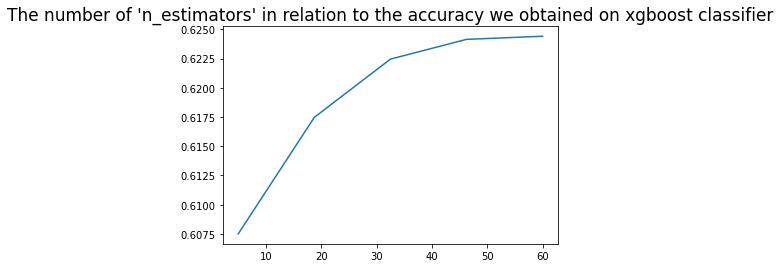

In [58]:
ax = plt.axes()
ax.plot(np.linspace(5, 60, num=5), accuracy_XGB_PCA)
plt.title("The number of 'n_estimators' in relation to the accuracy we obtained on xgboost classifier", fontsize=17, fontweight=100)

* ### As we can see n=60 is the best  'n_estimators'

In [70]:
#---------------xgboost classifier with PCA-----------------------
max_depth = [2,3,4,6,8]
accuracy_XGB_PCA = []

for n in max_depth:
    pipe_xgb_PCA = Pipeline([
        ("pca", PCA(n_components=0.65, random_state=42)),
        ("scale", StandardScaler()),
        ('xgb', XGBClassifier(learning_rate = 0.2, n_estimators=60, max_depth=n, seed=0, eval_metric='mlogloss'))
    ])

    y_pred_XGB_PCA = cross_val_predict(pipe_xgb_PCA, X_train_gray, y_train)

    #save the accuracy
    accuracy = accuracy_score(y_train,y_pred_XGB_PCA)
    accuracy_XGB_PCA.append(accuracy)

Text(0.5, 1.0, "The number of 'max_depth' in relation to the accuracy we obtained on xgboost classifier")

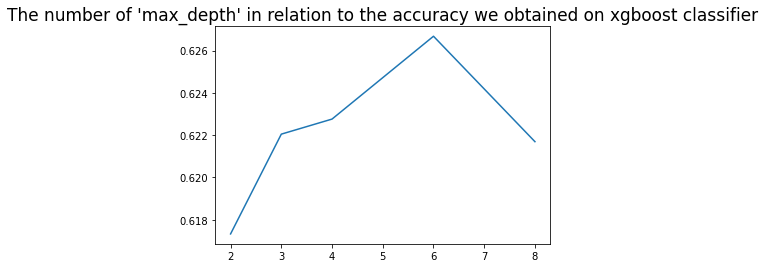

In [71]:
ax = plt.axes()
ax.plot(max_depth, accuracy_XGB_PCA)
plt.title("The number of 'max_depth' in relation to the accuracy we obtained on xgboost classifier", fontsize=17, fontweight=100)

* ### We can see that n=6 is the best  'max_depth' it's accuracy = <u>0.6266737844210152</u> 

### K-Neighbors Classifier 
* #### We will now find the ideal 'n' for 'n_neighbors'

In [59]:
#---------------KNN Classifier with PCA----------------
accuracy_KNN_PCA = []

for n in range(1,25):
    n = int(n)
    pipe_KNN_PCA = Pipeline([
         ("pca", PCA(n_components=0.65, random_state=42)),
        ("scale", StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=n))
    ])

    y_pred_KNN_PCA = cross_val_predict(pipe_KNN_PCA, X_train_gray, y_train)

    #save the accuracy
    accuracy = accuracy_score(y_train,y_pred_KNN_PCA)
    accuracy_KNN_PCA.append(accuracy)

Text(0.5, 1.0, "The number of 'n_neighbors' in relation to the accuracy we obtained on KNN classifier")

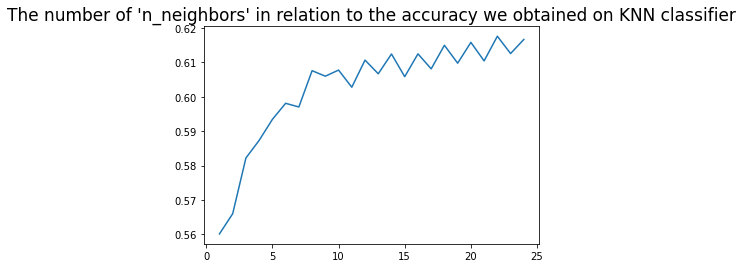

In [60]:
ax = plt.axes()
X = range(1,25)
ax.plot(X, accuracy_KNN_PCA)
plt.title("The number of 'n_neighbors' in relation to the accuracy we obtained on KNN classifier", fontsize=17, fontweight=100)

* ### It can be seen that the optimal 'n' is n = 20 and it's accuracy is <u>0.615819209039548</u>  

## We will now perform an ensemble model and try to create a better model:
### Voting Classifier

In [101]:
#---------------Voting Classifier with PCA of retained variance of 0.65 i.e. 18 components in this case----------------

pipe_VOT_065 = Pipeline([
     ("pca", PCA(n_components=0.65, random_state=42)),
    ("scale", StandardScaler()),
     ('voting_clf', VotingClassifier(
        estimators=[
            ('lg', LogisticRegression(multi_class='ovr',max_iter=100000)),
            ('rf', RandomForestClassifier()),
             ('knn', KNeighborsClassifier(n_neighbors=20)),
            ('EXT', ExtraTreesClassifier(n_estimators=300, max_depth=12, random_state=42)),
             ('xgb', XGBClassifier(learning_rate = 0.2, n_estimators=60, max_depth=6, seed=0, eval_metric='mlogloss'))
        ], voting='soft', n_jobs=-1))
])

y_pred_VOT_065 = cross_val_predict(pipe_VOT_065, X_train_gray, y_train,cv=3)

print(classification_report(y_train, y_pred_VOT_065,
                                digits=4, target_names=classes))

#save the accuracy
accuracy_VOT_065 = accuracy_score(y_train,y_pred_VOT_065)

              precision    recall  f1-score   support

        cats     0.6577    0.5681    0.6096     11226
        dogs     0.6207    0.7051    0.6602     11253

    accuracy                         0.6366     22479
   macro avg     0.6392    0.6366    0.6349     22479
weighted avg     0.6392    0.6366    0.6349     22479



In [102]:
#---------------Voting Classifier with PCA of retained variance of 0.75 i.e. 45 components in this case----------------

pipe_VOT_075 = Pipeline([
     ("pca", PCA(n_components=0.75, random_state=42)),
    ("scale", StandardScaler()),
     ('voting_clf', VotingClassifier(
        estimators=[
            ('lg', LogisticRegression(multi_class='ovr',max_iter=100000)),
            ('rf', RandomForestClassifier()),
             ('knn', KNeighborsClassifier(n_neighbors=20)),
            ('EXT', ExtraTreesClassifier(n_estimators=300, max_depth=12, random_state=42)),
             ('xgb', XGBClassifier(learning_rate = 0.2, n_estimators=60, max_depth=6, seed=0, eval_metric='mlogloss'))
        ], voting='soft', n_jobs=-1))
])

y_pred_VOT_075 = cross_val_predict(pipe_VOT_075, X_train_gray, y_train,cv=3)

print(classification_report(y_train, y_pred_VOT_075,
                                digits=4, target_names=classes))

#save the accuracy
accuracy_VOT_075 = accuracy_score(y_train,y_pred_VOT_075)

              precision    recall  f1-score   support

        cats     0.6669    0.5601    0.6089     11226
        dogs     0.6216    0.7210    0.6676     11253

    accuracy                         0.6406     22479
   macro avg     0.6443    0.6405    0.6383     22479
weighted avg     0.6443    0.6406    0.6383     22479



<function matplotlib.pyplot.show(*args, **kw)>

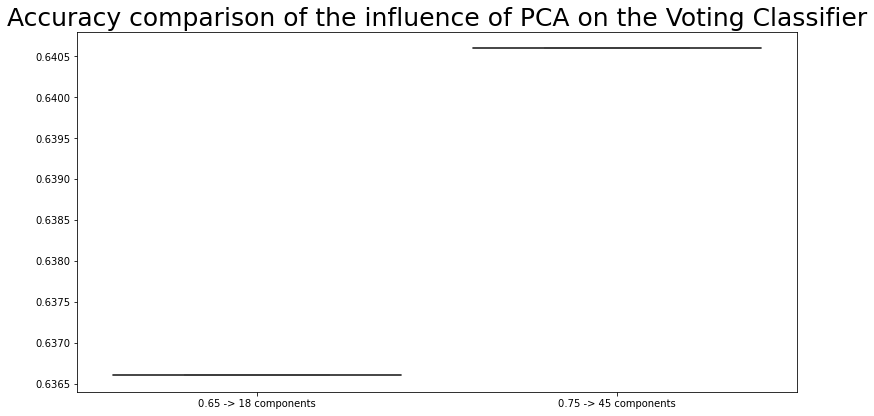

In [104]:
Models = ["0.65 -> 18 components", "0.75 -> 45 components"]
Accuracy = [0.6366, 0.6406]

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
x = Models
y = Accuracy
sns.boxplot(x=x, y=y)
plt.title("Accuracy comparison of the influence of PCA on the Voting Classifier",fontsize=25)
plt.show

* ### Since both models got a significant reduction in dimensions, a decrease from 4,096 to 45/18 dimensions, I will choose to take the model according to the better result, which is the 45-dimensional model.
* ### Because my goal is to work with the most reduced model while maintaining high accuracy <u>I will choose to go with the 45-dimensional model.</u> 

# <u> Additional improvement attempts:</u>

* ## 1.  Attempt to process an image - an attempt that failed with the knowledge I currently have.
* ## 2. Using K-MEANS - In fact it did not improve the result.

## Attempt to process an image:
* ### I tried to cut the image with a 'open-CV' around the face of the animals to improve the accuracy and refer only to the face without the background and other distractions, but I saw that the cut of the face does not work well enough so after many attempts I gave up on this idea.
* ### It will be interesting to see if successful use of this method will lead to better results.

In [136]:
# read image as grayscale and resize to 600X600

def read_image_grayscale_600 (file_path):
#   print(file_path)
  img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#   print(img)
  return cv2.resize(img, (600, 600), interpolation=cv2.INTER_CUBIC)

In [43]:
catface_cascade = cv2.CascadeClassifier(r'C:\Users\Aviva\Desktop\catface_detector.xml')

file_path = os.path.join("/kaggle/train/"+sample)
img = read_image_grayscale_600(file_path)

cat_faces = catface_cascade.detectMultiScale(img, scaleFactor=1.01, 
minNeighbors=5, minSize=(75, 75))

for (i, (x, y, w, h)) in enumerate(cat_faces):
   cv2.rectangle(img, (x, y), (x+w, y+h), (0,255, 0), 3)
   cv2.putText(img, "Cat Faces", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 0, 255), 2)

* ### Images that successfully detected and not successfully detected for example:

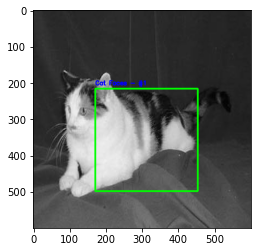

In [44]:
# Image not successfully detected:
plt.imshow(bad_img)

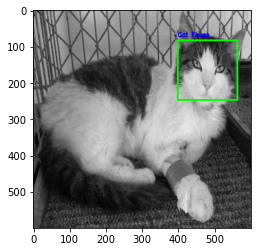

In [45]:
# Image successfully detected:
plt.imshow(good_img)

## Using K-MEANS

In [109]:
#-----Voting Classifier with best K-MEANS (89) and with PCA of retained variance of 0.65 i.e. 18 components in this case-----

pipe_VOT_KMEANS_065 = Pipeline([
     ("pca", PCA(n_components=0.65, random_state=42)),
    ("scale", StandardScaler()),
    ("kmeans", KMeans(n_clusters=89)),
     ('voting_clf', VotingClassifier(
        estimators=[
            ('lg', LogisticRegression(multi_class='ovr',max_iter=100000)),
            ('rf', RandomForestClassifier()),
             ('knn', KNeighborsClassifier(n_neighbors=20)),
            ('EXT', ExtraTreesClassifier(n_estimators=300, max_depth=12, random_state=42)),
             ('xgb', XGBClassifier(learning_rate = 0.2, n_estimators=60, max_depth=6, seed=0, eval_metric='mlogloss'))
        ], voting='soft', n_jobs=-1))
])

y_pred_VOT_KMEANS_065 = cross_val_predict(pipe_VOT_KMEANS_065, X_train_gray, y_train, cv=3)

print(classification_report(y_train, y_pred_VOT_KMEANS_065,
                                digits=4, target_names=classes))

#save the accuracy
accuracy_VOT_KMEANS_065 = accuracy_score(y_train,y_pred_VOT_KMEANS_065)

              precision    recall  f1-score   support

        cats     0.6307    0.6334    0.6321     11226
        dogs     0.6327    0.6300    0.6313     11253

    accuracy                         0.6317     22479
   macro avg     0.6317    0.6317    0.6317     22479
weighted avg     0.6317    0.6317    0.6317     22479



In [91]:
param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipe_VOT_KMEANS_075, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train_gray, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] kmeans__n_clusters=2 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................. kmeans__n_clusters=2, total= 2.0min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s


[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total= 1.9min
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total= 1.9min
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total= 2.0min
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total= 1.9min
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total= 1.9min
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total= 2.1min
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total= 2.0min
[CV] k

[CV] ............................ kmeans__n_clusters=21, total= 2.7min
[CV] kmeans__n_clusters=22 ...........................................
[CV] ............................ kmeans__n_clusters=22, total= 2.5min
[CV] kmeans__n_clusters=22 ...........................................
[CV] ............................ kmeans__n_clusters=22, total= 2.7min
[CV] kmeans__n_clusters=22 ...........................................
[CV] ............................ kmeans__n_clusters=22, total= 2.5min
[CV] kmeans__n_clusters=23 ...........................................
[CV] ............................ kmeans__n_clusters=23, total= 2.8min
[CV] kmeans__n_clusters=23 ...........................................
[CV] ............................ kmeans__n_clusters=23, total= 2.5min
[CV] kmeans__n_clusters=23 ...........................................
[CV] ............................ kmeans__n_clusters=23, total= 2.6min
[CV] kmeans__n_clusters=24 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=41, total= 2.5min
[CV] kmeans__n_clusters=41 ...........................................
[CV] ............................ kmeans__n_clusters=41, total= 2.5min
[CV] kmeans__n_clusters=41 ...........................................
[CV] ............................ kmeans__n_clusters=41, total= 2.4min
[CV] kmeans__n_clusters=42 ...........................................
[CV] ............................ kmeans__n_clusters=42, total= 2.5min
[CV] kmeans__n_clusters=42 ...........................................
[CV] ............................ kmeans__n_clusters=42, total= 2.4min
[CV] kmeans__n_clusters=42 ...........................................
[CV] ............................ kmeans__n_clusters=42, total= 2.4min
[CV] kmeans__n_clusters=43 ...........................................
[CV] ............................ kmeans__n_clusters=43, total= 2.4min
[CV] kmeans__n_clusters=43 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=60, total=15.9min
[CV] kmeans__n_clusters=60 ...........................................
[CV] ............................ kmeans__n_clusters=60, total= 3.6min
[CV] kmeans__n_clusters=61 ...........................................
[CV] ............................ kmeans__n_clusters=61, total= 3.7min
[CV] kmeans__n_clusters=61 ...........................................
[CV] ............................ kmeans__n_clusters=61, total= 3.5min
[CV] kmeans__n_clusters=61 ...........................................
[CV] ............................ kmeans__n_clusters=61, total= 3.5min
[CV] kmeans__n_clusters=62 ...........................................
[CV] ............................ kmeans__n_clusters=62, total= 3.8min
[CV] kmeans__n_clusters=62 ...........................................
[CV] ............................ kmeans__n_clusters=62, total= 3.5min
[CV] kmeans__n_clusters=62 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=79, total= 4.1min
[CV] kmeans__n_clusters=80 ...........................................
[CV] ............................ kmeans__n_clusters=80, total= 3.8min
[CV] kmeans__n_clusters=80 ...........................................
[CV] ............................ kmeans__n_clusters=80, total= 4.2min
[CV] kmeans__n_clusters=80 ...........................................
[CV] ............................ kmeans__n_clusters=80, total= 3.9min
[CV] kmeans__n_clusters=81 ...........................................
[CV] ............................ kmeans__n_clusters=81, total= 4.3min
[CV] kmeans__n_clusters=81 ...........................................
[CV] ............................ kmeans__n_clusters=81, total= 3.8min
[CV] kmeans__n_clusters=81 ...........................................
[CV] ............................ kmeans__n_clusters=81, total= 3.8min
[CV] kmeans__n_clusters=82 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=99, total=11.0min
[CV] kmeans__n_clusters=99 ...........................................
[CV] ............................ kmeans__n_clusters=99, total=11.8min
[CV] kmeans__n_clusters=99 ...........................................
[CV] ............................ kmeans__n_clusters=99, total= 8.0min


[Parallel(n_jobs=1)]: Done 294 out of 294 | elapsed: 1601.4min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca',
                                        PCA(n_components=0.75,
                                            random_state=42)),
                                       ('scale', StandardScaler()),
                                       ('kmeans', KMeans(n_clusters=50)),
                                       ('voting_clf',
                                        VotingClassifier(estimators=[('lg',
                                                                      LogisticRegression(max_iter=100000,
                                                                                         multi_class='ovr')),
                                                                     ('rf',
                                                                      RandomForestClassifier()),
                                                                     ('knn',
                                                                      

In [92]:
# Let’s look at the best value for k and the performance of the resulting pipeline:

grid_clf.best_params_

{'kmeans__n_clusters': 89}

### Dummy Classifier
* #### Each model must be at least better than Dummy Classifier to be considered a good model

In [108]:
# to run ___
#-------- Dummy Classifier -------
pipe_dm = Pipeline([
     ("pca", PCA(n_components=0.65, random_state=42)),
    ("scale", StandardScaler()),
    ('dm', DummyClassifier(strategy = 'most_frequent'))
])

y_pred_dm = cross_val_predict(pipe_dm, X_train_gray, y_train, cv=3)

print(classification_report(y_train, y_pred_dm,
                                digits=4, target_names=classes))

#save the accuracy
accuracy_dm = accuracy_score(y_train,y_pred_dm)

              precision    recall  f1-score   support

        cats     0.0000    0.0000    0.0000     11226
        dogs     0.5006    1.0000    0.6672     11253

    accuracy                         0.5006     22479
   macro avg     0.2503    0.5000    0.3336     22479
weighted avg     0.2506    0.5006    0.3340     22479



# Final Results - Comparing the best models

<function matplotlib.pyplot.show(*args, **kw)>

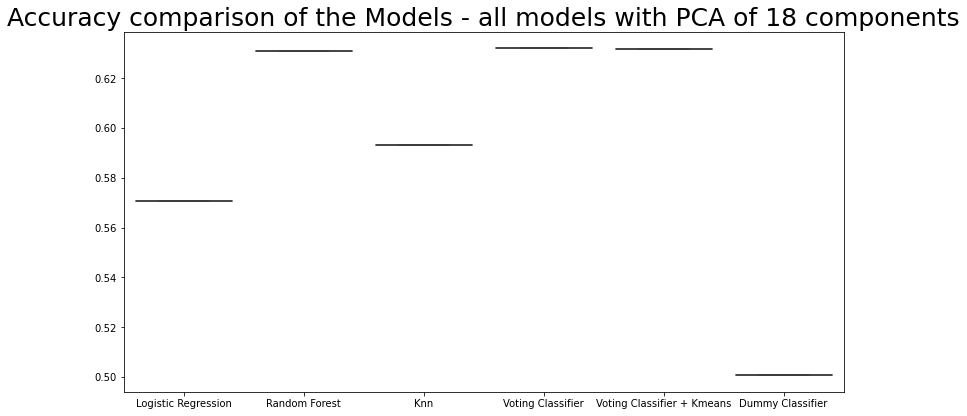

In [132]:
Models = ["Logistic Regression", "Random Forest", "Knn", "Voting Classifier", "Voting Classifier + Kmeans", "Dummy Classifier"]
Accuracy = [0.5706,  0.6309, 0.5931, 0.6321, 0.6317, 0.5006]

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
x = Models
y = Accuracy
sns.boxplot(x=x, y=y)
plt.title("Accuracy comparison of the Models - all models with PCA of 18 components",fontsize=25)
plt.show

* ## In conclusion, I will choose the ensemble model without Kmeans as my model, as it has the highest accuracy.
* ## In addition it can be seen that it is very close to a random forest but I prefer the ensemble model because it is stronger in the sense that it is built from more 'viewing angles' (perspective) of the data

# <u> Test the model:</u>
### As we talked (on email) I chose to present 2 different tests for my model:
* ### 1.  A test based on the data I initially split from the Data Train, this test will be measured on 'accuracy.
* ### 2. A test that will be based on the data from Kegel's data test, this test will be measured on 'Log Loss' as this is the index that exists in Kegel for this competition.  

### *Log-loss is indicative of how close the prediction probability is to the corresponding actual/true value (0 or 1 in case of binary classification). The more the predicted probability diverges from the actual value, the higher is the log-loss value.

### 1. Test by 'accuracy' on data split from the data train

In [112]:
pipe_VOT_075 = Pipeline([
     ("pca", PCA(n_components=0.75, random_state=42)),
    ("scale", StandardScaler()),
     ('voting_clf', VotingClassifier(
        estimators=[
            ('lg', LogisticRegression(multi_class='ovr',max_iter=100000)),
            ('rf', RandomForestClassifier()),
             ('knn', KNeighborsClassifier(n_neighbors=20)),
            ('EXT', ExtraTreesClassifier(n_estimators=300, max_depth=12, random_state=42)),
             ('xgb', XGBClassifier(learning_rate = 0.2, n_estimators=60, max_depth=6, seed=0, eval_metric='mlogloss'))
        ], voting='soft', n_jobs=-1))
])

pipe_VOT_075.fit(X_train_gray, y_train)

print(classification_report(y_test_gry, y_pred,
                                digits=4, target_names=classes))
#save the accuracy
accuracy_VOT_075_Test = accuracy_score(y_test_gry,y_pred)

              precision    recall  f1-score   support

        cats     0.6805    0.5582    0.6133      1263
        dogs     0.6183    0.7320    0.6704      1235

    accuracy                         0.6441      2498
   macro avg     0.6494    0.6451    0.6418      2498
weighted avg     0.6498    0.6441    0.6415      2498



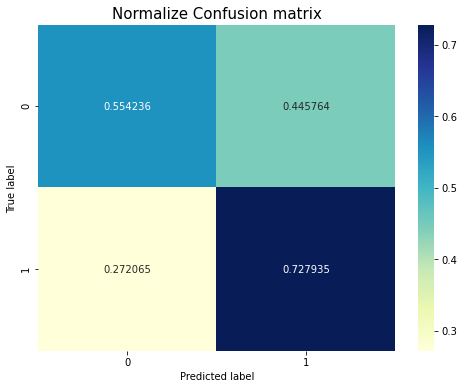

In [130]:
#----------------------Normalize Confusion matrix------------------------------------
from sklearn.metrics import plot_confusion_matrix

y_pred = pipe_VOT_075.predict(X_test_gry)
con_mat = confusion_matrix(y_test_gry, y_pred,normalize='true')
f, ax = plt.subplots(figsize=(8, 6))
plt.title('Normalize Confusion matrix', size = 15)
sns.heatmap(con_mat, annot=True, fmt='g',cmap="YlGnBu")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

* ## cat = 0
* ## dog = 1

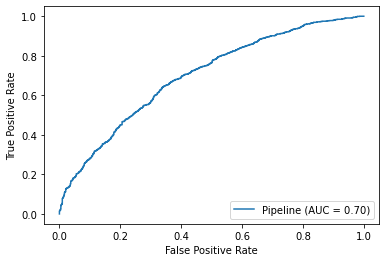

In [125]:
from sklearn import metrics
ROC =  metrics.plot_roc_curve(pipe_VOT_075,X_test_gry, y_test_gry)
plt.show()  

### 2. Test by 'Log Loss' on data from 'Kegel'

In [116]:
# load the data:
filenames = os.listdir("/kaggle/test1")

# Creates that the first DataFrame:
df_gray = pd.DataFrame({
    'filename': filenames
})
#---------------------------------------

# Creates a columns names for the secend dataframe
columns=[]
for i in range(1,4097):
    temp = "pixel {}".format(str(i))
    columns.append(temp)
#----------------------------------------    

# Creates a dataframe of the images:
data_gray =[]
for fname in df_gray['filename']:
    file_path = os.path.join("/kaggle/test1/"+fname)
    img = read_image_grayscale(file_path)
    img = img.flatten() 
    data_gray.append(img)
df_img_gry = pd.DataFrame.from_records(data_gray,columns=columns)
#----------------------------------------    

# "Merge" the 2 dataframe to 1:
df_img_gry = pd.concat([df_img_gry, df_gray], axis=1)

#----------------------------------------    
df_img_gry_Test = df_img_gry.drop(['filename'],axis=1)
df_img_gry_Test

,pixel 1,pixel 2,pixel 3,pixel 4,pixel 5,pixel 6,pixel 7,pixel 8,pixel 9,pixel 10,...,pixel 4087,pixel 4088,pixel 4089,pixel 4090,pixel 4091,pixel 4092,pixel 4093,pixel 4094,pixel 4095,pixel 4096
0,57,49,63,66,64,59,61,67,56,47,...,171,89,112,132,183,199,91,129,149,80
1,9,9,9,5,126,101,95,70,63,56,...,124,101,110,99,87,93,75,78,69,73
2,2,3,2,2,4,5,6,9,10,7,...,232,230,251,249,250,244,249,250,252,255
3,155,137,127,182,161,150,143,122,188,131,...,90,171,190,166,156,125,159,120,140,167
4,156,220,211,219,234,221,217,189,223,203,...,181,224,206,141,124,127,132,140,134,140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12495,39,46,52,58,59,67,78,97,121,139,...,142,126,137,130,144,125,138,109,131,110
12496,120,50,234,143,101,188,228,201,186,186,...,4,62,27,38,31,70,16,30,8,35
12497,234,231,217,229,239,223,243,212,191,233,...,186,124,124,111,161,137,107,122,116,121
12498,106,122,136,143,164,174,176,167,160,154,...,128,130,132,118,131,129,120,120,122,125


In [117]:
X_test_kagel = df_img_gry_Test

X_test_kagel

,pixel 1,pixel 2,pixel 3,pixel 4,pixel 5,pixel 6,pixel 7,pixel 8,pixel 9,pixel 10,...,pixel 4087,pixel 4088,pixel 4089,pixel 4090,pixel 4091,pixel 4092,pixel 4093,pixel 4094,pixel 4095,pixel 4096
0,57,49,63,66,64,59,61,67,56,47,...,171,89,112,132,183,199,91,129,149,80
1,9,9,9,5,126,101,95,70,63,56,...,124,101,110,99,87,93,75,78,69,73
2,2,3,2,2,4,5,6,9,10,7,...,232,230,251,249,250,244,249,250,252,255
3,155,137,127,182,161,150,143,122,188,131,...,90,171,190,166,156,125,159,120,140,167
4,156,220,211,219,234,221,217,189,223,203,...,181,224,206,141,124,127,132,140,134,140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12495,39,46,52,58,59,67,78,97,121,139,...,142,126,137,130,144,125,138,109,131,110
12496,120,50,234,143,101,188,228,201,186,186,...,4,62,27,38,31,70,16,30,8,35
12497,234,231,217,229,239,223,243,212,191,233,...,186,124,124,111,161,137,107,122,116,121
12498,106,122,136,143,164,174,176,167,160,154,...,128,130,132,118,131,129,120,120,122,125


In [119]:
pipe_VOT_075 = Pipeline([
     ("pca", PCA(n_components=0.75, random_state=42)),
    ("scale", StandardScaler()),
     ('voting_clf', VotingClassifier(
        estimators=[
            ('lg', LogisticRegression(multi_class='ovr',max_iter=100000)),
            ('rf', RandomForestClassifier()),
             ('knn', KNeighborsClassifier(n_neighbors=20)),
            ('EXT', ExtraTreesClassifier(n_estimators=300, max_depth=12, random_state=42)),
             ('xgb', XGBClassifier(learning_rate = 0.2, n_estimators=60, max_depth=6, seed=0, eval_metric='mlogloss'))
        ], voting='soft', n_jobs=-1))
])
pipe_VOT_075.fit(X_train_gray, y_train)
y_pred = pipe_VOT_075.predict(X_test_kagel)
y_pred_prob = pipe_VOT_075.predict_proba(X_test_kagel)[:,1]

In [121]:
# create a submission to test my model on 'kaggle':

data =[]
j=1
for i in range (0,12500):
    data.append(j)
    j=j+1

submission = pd.DataFrame({ 'id': data, 'label': y_pred_prob})
submission.to_csv("my_submission.csv", index=False)
submission

,id,label
0,1,0.449916
1,2,0.445619
2,3,0.405359
3,4,0.411978
4,5,0.566656
...,...,...
12495,12496,0.529143
12496,12497,0.556109
12497,12498,0.673534
12498,12499,0.499614


# The final submission from kaggel:
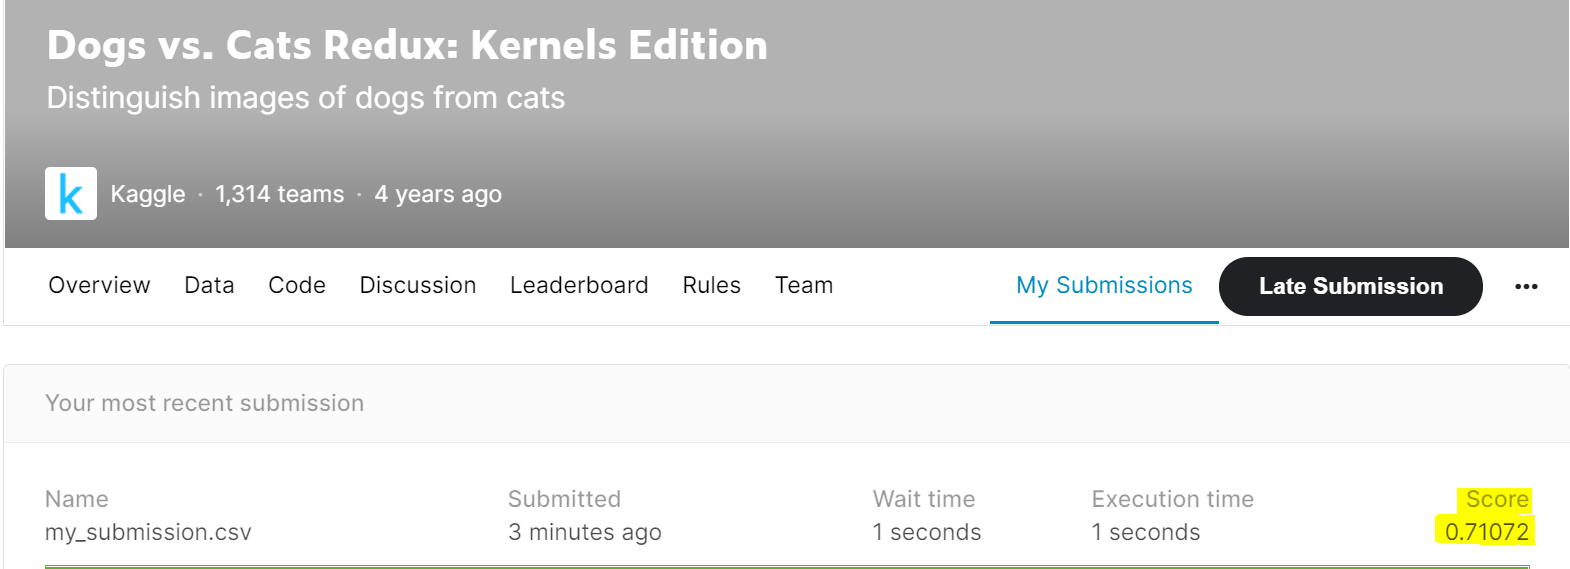
* ### Link to the kaggle competitions: __[My submission on kaggel](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/submissions)__

# <u> In conclusion:</u>
* ## We used PCA and reduced <u>from 4,096 to 45</u> dimensions only (!)
* ## In the test on the split data from the data train, we obtained an accuracy of <u>64.41%</u>
* ## And in the original test of the 12,500 samples, that we submitted on Kegel, we obtained an Log Loss of <u>0.71072</u>